### Библиотеки

In [2]:
import sys
sys.path.append("../modules")
sys.path.append("../dataset")
sys.path.append("../Moore-AnimateAnyone")

from torch.nn import CosineSimilarity
import torch
from transformers import CLIPVisionModelWithProjection, CLIPImageProcessor

from PIL import Image
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import torch

from metrics import get_cosine_similarity, get_pose_distance

### Пример данных 

Сравним метрики:

* оригинальный кадр с оригинальным
* оригинальный кадр с шумом

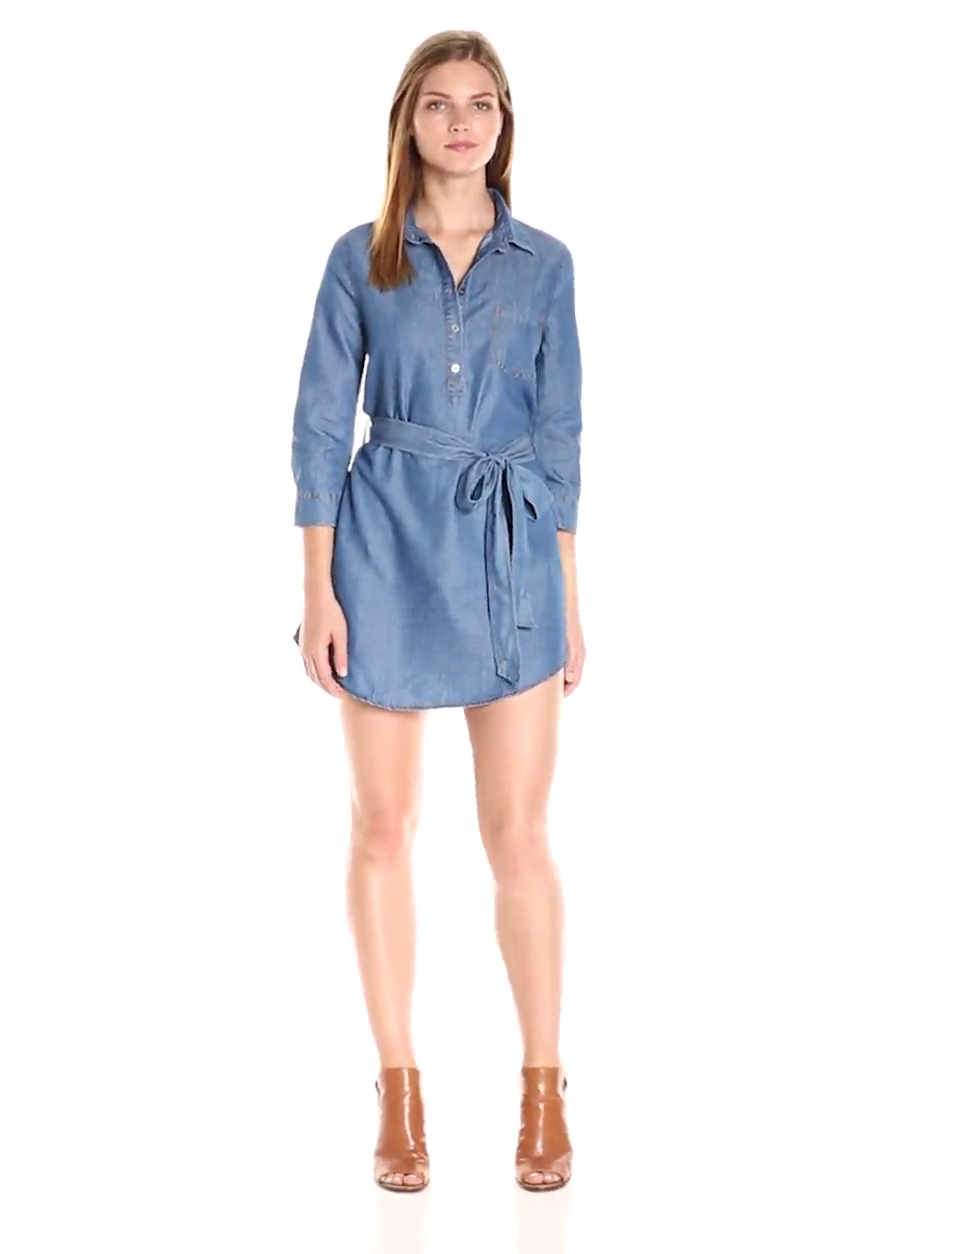

In [3]:
# оригинальный кадр
souce_image = Image.open("../dataset/test/stage_1/sample_0/source.png")
souce_image

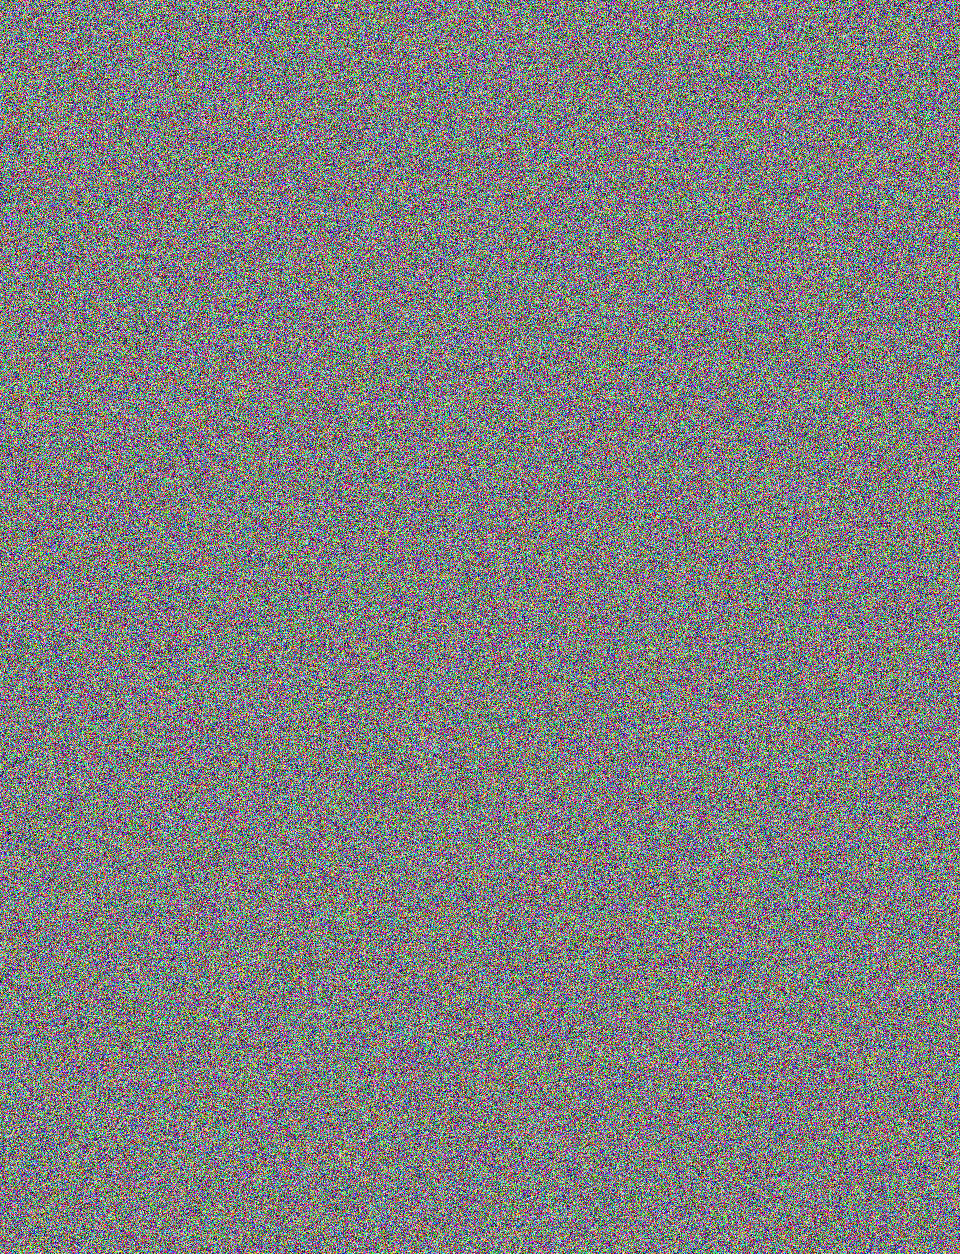

In [4]:
# шум
rand_tensor = torch.randn(pil_to_tensor(souce_image).shape)
noise = to_pil_image(rand_tensor)
noise

### CLIP

Чем боль метрика, тем сильнее похоже объекты

In [8]:
# подгрудаем веса предобученного CLIPImageProcessor
import os
os.chdir('../Moore-AnimateAnyone')
from src.dwpose import DWposeDetector

clip_image_processor = CLIPImageProcessor()
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "./pretrained_weights/image_encoder"
).to(dtype=torch.float16, device="cuda")

os.chdir('../notebooks')

In [9]:
clip_sim = get_cosine_similarity(souce_image, noise, clip_image_processor, image_encoder)
print(f"Сравненеие с шумом: {round(clip_sim, 2)}")

Сравненеие с шумом: 0.46


In [10]:
clip_sim = get_cosine_similarity(souce_image, souce_image, clip_image_processor, image_encoder)
print(f"Сравненеие с оригиналом: {round(clip_sim, 2)}")

Сравненеие с оригиналом: 1.0


### PoseEstemator

Чем больше метрика, тем больше расстояние

In [11]:
# подгрудаем веса предобученного DWposeDetector
import os
os.chdir('../Moore-AnimateAnyone')
from src.dwpose import DWposeDetector

detector = DWposeDetector()
detector = detector.to(f"cuda")
os.chdir('../notebooks')

2025-04-13 14:59:20.085808167 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2025-04-13 14:59:20.085841084 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [12]:
pose_sim = get_pose_distance(souce_image, noise, detector)
print(f"Сравненеие с шумом: {round(pose_sim, 2)}")

Сравненеие с шумом: 20.48


In [13]:
pose_sim = get_pose_distance(souce_image, souce_image, detector)
print(f"Сравненеие с оригиналом: {round(pose_sim, 2)}")

Сравненеие с оригиналом: 0.0


___